In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh

from os import path

reload(read)
import wf_analysis.datasets as wfdata



# Age predictions

In [3]:
edfRawData = read.EdfDataset("train", "01_tcp_ar", n_process=8, filter=False)

In [13]:
reload(wfdata)
bptData = wfdata.CoherenceTransformer([rawData], n_process=8, coherence_all=True, columns_to_use=constants.SMALLEST_COLUMN_SUBSET)
bptDatum = bptData[0]

In [14]:
len(bptData.columns_to_use)
bptDatum

(coherence ('EEG F4-REF', 'EEG C4-REF')    0.186159
 coherence ('EEG F4-REF', 'EEG O2-REF')    0.051225
 coherence ('EEG C4-REF', 'EEG O2-REF')    0.107757
 dtype: float64,
                  null  spsw  gped  pled  eybl  artf  bckg  seiz  fnsz  gnsz  \
 00:00:00            0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.008000     0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.016000     0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.024000     0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.032000     0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.040000     0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.048000     0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.056000     0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.064000     0     0     0     0     0     0   1.0     0     0     0   
 00:00:00.072000     0     

In [11]:
rawData = edfRawData[0]

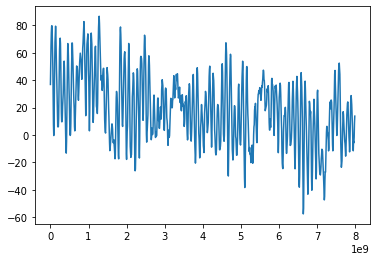

In [40]:
plt.plot(rawData[0]["EEG T5-REF"].iloc[0:1000])

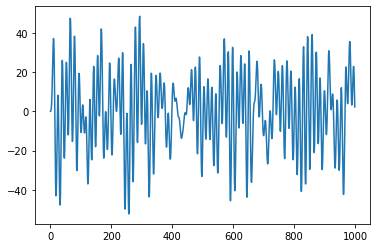

In [41]:
plt.plot(bptDatum[0]["EEG T5-REF(1, 10)"].iloc[0:1000])

In [46]:
bptDatum[0].shape, rawData[0].shape

((163125, 21), (163125, 21))

TypeError: should_use_mp() takes 2 positional arguments but 3 were given

In [20]:
#based on https://www.ers-education.org/lrmedia/2016/pdf/298830.pdf
columns_to_use = ['EEG F4-REF','EEG C4-REF','EEG O2-REF',]
edfRawData = read.EdfDataset("train", "01_tcp_ar", n_process=7, filter=False, columns_to_use=columns_to_use)
edfABTGData = read.EdfFFTDatasetTransformer(edfRawData, freq_bins=constants.FREQ_BANDS) #gamma, theta, alpha, beta

In [17]:
res = cta.getAgesAndFileNames("train", "01_tcp_ar")
singAges = [datum[1] for datum in res]
fn = [datum[0] for datum in res]
ages = []
#associate first token file with each session for now
tokenFiles = []
for i, session_file in enumerate(fn):
    session_dir = path.dirname(session_file)
    session_tkn_files = read.get_token_file_names(session_dir)
    session_tkn_files.sort()
    tokenFiles += (session_tkn_files)
    ages += [singAges[i] for j in session_tkn_files]
edfRawData.edf_tokens=tokenFiles

In [21]:
max(ages)

88

In [22]:
def norm_num_peaks_func(n):
    return lambda x: feats.number_peaks(x, n) / len(x)

def norm_num_vals_func(n):
    return lambda x: feats.number_peaks(-x, n) / len(x)

def autocorrelation(lag):
    return lambda x: feats.autocorrelation(x, lag)


In [15]:
reload(read)
hedDf = read.SimpleHandEngineeredDataset(edfRawData, vectorize=None, max_size=pd.Timedelta(minutes=2), n_process = 4, features=[feats.abs_energy, max, min, norm_num_peaks_func(20), norm_num_vals_func(20), autocorrelation(60), feats.skewness, feats.standard_deviation], f_names=["abs_energy", "max", "min", "num_peaks", "num_valleys", "autocorrelation", "skewness", "stdev"])
hed = read.SimpleHandEngineeredDataset(edfRawData, vectorize="full", max_size=pd.Timedelta(minutes=2), n_process = 6, features=[feats.abs_energy, max, min, norm_num_peaks_func(20), norm_num_vals_func(20), autocorrelation(60), feats.skewness, feats.standard_deviation], f_names=["abs_energy", "max", "min", "num_peaks", "num_valleys", "autocorrelation", "skewness", "stdev"])

In [14]:
datum = hedDf[0]
datum

,abs_energy,max,min,num_peaks,num_valleys,autocorrelation,skewness,stdev
EEG T5-REF,2.257518e+08,262.702422,-246.311310,0.021333,0.020383,0.637449,-0.147412,37.200712
EEG C3-REF,1.900837e+08,283.168256,-292.144861,0.020812,0.020512,0.906437,0.729655,34.135892
EEG A1-REF,5.770426e+08,593.722518,-541.034590,0.020837,0.020346,0.779434,0.820138,59.476262
EEG P4-REF,1.259029e+08,211.337563,-233.169688,0.020641,0.020549,0.764491,-0.893534,27.781471
EEG F8-REF,4.945970e+08,355.227831,-414.100638,0.018458,0.019175,0.824403,-0.043648,55.063427
EEG F3-REF,4.282366e+08,930.369288,-350.242655,0.019126,0.019053,0.851090,3.094298,51.236745
EEG CZ-REF,5.256018e+07,127.776685,-108.886948,0.020297,0.020175,0.918033,-0.065100,17.949732
EEG O2-REF,2.197932e+08,236.323811,-262.828936,0.020812,0.020696,0.565049,-0.665764,36.706585
EEG A2-REF,2.684374e+08,340.655699,-337.482503,0.020573,0.020647,0.742202,0.446701,40.565733
EEG P3-REF,1.792142e+08,320.113571,-349.441570,0.021168,0.020500,0.763361,-1.278316,33.145376


In [56]:
# import all the data!
max_size = len(hed)
print(max_size)
allHandEngineeredData = hed[:max_size]


2584
Starting 6 processes
retrieving: 0
retrieving: 5
retrieving: 10
retrieving: 15
retrieving: 20
retrieving: 25
retrieving: 30
retrieving: 35
retrieving: 40
retrieving: 45
retrieving: 50
retrieving: 55
retrieving: 60
retrieving: 65
retrieving: 70
retrieving: 75
retrieving: 80
retrieving: 85
retrieving: 90
retrieving: 95
retrieving: 100
retrieving: 105
retrieving: 110
retrieving: 115
retrieving: 120
retrieving: 125
retrieving: 130
retrieving: 135
retrieving: 140
retrieving: 145
retrieving: 150
retrieving: 155
retrieving: 160
retrieving: 165
retrieving: 170
retrieving: 175
retrieving: 180
retrieving: 185
retrieving: 190
retrieving: 195
retrieving: 200
retrieving: 205
retrieving: 210
retrieving: 215
retrieving: 220
retrieving: 225
retrieving: 230
retrieving: 235
retrieving: 240
retrieving: 245
retrieving: 250
retrieving: 255
retrieving: 260
retrieving: 265
retrieving: 270
retrieving: 275
retrieving: 280
retrieving: 285
retrieving: 290
retrieving: 295
retrieving: 300
retrieving: 305
retr

retrieving: 2470
retrieving: 2475
retrieving: 2480
retrieving: 2485
retrieving: 2490
retrieving: 2495
retrieving: 2500
retrieving: 2505
retrieving: 2510
retrieving: 2515
retrieving: 2520
retrieving: 2525
retrieving: 2530
retrieving: 2535
retrieving: 2540
retrieving: 2545
retrieving: 2550
retrieving: 2555
retrieving: 2560
retrieving: 2565
retrieving: 2570
retrieving: 2575
retrieving: 2580
Process completed
Process completed
Process completed
Process completed
Process completed


In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
lr = LinearRegression()

In [58]:
sum([type(datum) == int for datum in allHandEngineeredData])

1

In [70]:
trainSlice = slice(max_size - 100)
testSlice = slice(-100, None)
allHandEngineeredData = np.nan_to_num(allHandEngineeredData)
trainData = (mm.fit_transform(np.stack(allHandEngineeredData[trainSlice])))
testData = (mm.fit_transform(np.stack(allHandEngineeredData[testSlice])))
trainAges = (np.array(ages[trainSlice]).reshape(-1,1))
testAges = (np.array(ages[testSlice]).reshape(-1,1))
trainData.shape
testData.shape

(100, 168)

In [69]:
max_size = 500

In [71]:
np.isnan(trainData).any().any(), np.isnan(trainData).any().any()

(True, True)

In [64]:
feat_sel = chi2(trainData, trainAges)[1] < 0.5
originalTrainData = trainData
originalTestData = testData
trainData= trainData[:,feat_sel]
testData = testData[:,feat_sel]

# feat_sel = slice(-1)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
lr.fit(trainData[:], trainAges)
y_pred = lr.predict(testData[:])
y_pred[y_pred < 20] = 20
y_pred[y_pred > 90] = 90
r2_score(y_pred, testAges)

In [ ]:
from scipy.stats import pearsonr
testAgesR = mm.fit_transform(testAges)
y_predR = mm.transform(y_pred.reshape(-1, 1))
print('adjusted r^2 score', r2_score(y_predR, testAgesR))
print('r score ', pearsonr(y_predR.reshape(-1), testAgesR.reshape(-1)))
print('r^2 score ', pearsonr(y_predR.reshape(-1), testAgesR.reshape(-1))[0]**2)
plt.plot(y_pred, testAges, "*")
plt.xlabel("Prediction")
plt.ylabel("Actual")

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RF
from scipy.stats.stats import pearsonr
rf = RF(n_estimators=10, max_depth=3)
rf.fit(np.nan_to_num(trainData), trainAges)
y_pred = rf.predict(testData)
plt.plot(y_pred, testAges, "*")
print('adjusted r^2 score', r2_score(y_pred, testAges))
print('r score ', pearsonr(y_pred, testAges.reshape(-1)))
print('r^2 score ', pearsonr(y_pred, testAges.reshape(-1))[0]**2)

plt.xlabel("Prediction")
plt.ylabel("Actual")

# BPM predictions

In [128]:
allColumns = util_funcs.get_common_channel_names()
allColumns

['EEG T5-REF',
 'EEG C3-REF',
 'EEG A1-REF',
 'EEG P4-REF',
 'EEG F8-REF',
 'EEG F3-REF',
 'EEG CZ-REF',
 'EEG O2-REF',
 'EEG A2-REF',
 'EEG P3-REF',
 'EEG C4-REF',
 'EEG O1-REF',
 'EEG T4-REF',
 'EEG F4-REF',
 'EEG F7-REF',
 'EEG PZ-REF',
 'EEG FP1-REF',
 'EEG FZ-REF',
 'EEG T3-REF',
 'EEG T6-REF',
 'EEG FP2-REF']

In [35]:
#based on https://www.ers-education.org/lrmedia/2016/pdf/298830.pdf
columns_to_use = ['EEG F4-REF','EEG C4-REF','EEG O2-REF',]

In [129]:
edfRawDataBPM = read.EdfDataset("train", "01_tcp_ar", n_process=7, filter=False, columns_to_use=columns_to_use)
# edfRawDataBPM = read.EdfDataset("train", "01_tcp_ar", n_process=8, filter=False)

In [28]:
resBPM = cta.getBPMAndFileNames("train", "01_tcp_ar")
singBPM = [datum[1] for datum in resBPM]
fn = [datum[0] for datum in resBPM]
bpms = []
#associate first token file with each session for now
tokenFiles = []
for i, session_file in enumerate(fn):
    session_dir = path.dirname(session_file)
    session_tkn_files = read.get_token_file_names(session_dir)
    session_tkn_files.sort()
    tokenFiles += (session_tkn_files)
    bpms += [singBPM[i] for j in session_tkn_files]
# edfRawDataBPM.edf_tokens=tokenFiles

In [30]:
minVal = min([res[1] for res in resBPM])
print(minVal)
[res[0] if res[1] == minVal else "" for res in resBPM]

24


['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',


In [34]:
bpms.sort()
bpms

[24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 24,
 48,
 56,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 60,
 64,
 65,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,
 66,


In [31]:
%%bash
cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/119/00011902/s010_2014_08_12/00011902_s010.txt

History:	53 YR FEMALE WITH WITNESS SZ.  PT STOPPED DILANTIN 3-4 DYS AGO. TREATED FOR TB HEPATITIS, SZS, ESOPHAGEAL VARICES
Medications:	Lorazepam, Dilantin
Sedation:
EEG Type:	Routine, awake & drowsy, portable
Technique:	International 10-20 System; standard 21 electrodes with T1/T2 electrodes, lethargic
Description:
No posterior dominant rhythm was present.  Background activity was characterized by diffuse low voltage delta and theta activity with absence of the expected anterior to posterior gradient of frequencies.  No normal sleep architecture was present. Intermittent polymorphic delta activity is present in the left parieto central region.  Frequent sharp waves are present at P3/C3 at times they appeared to be periodic at 1Hz. At times they also appear in runs of alpha frequency discharges that do not clearly evolve.  No clinical or electrographic seizures.
Hyperventilation and photic stimulation were not performed.  There was no reactivity to auditory, tactile, or painful stimuli

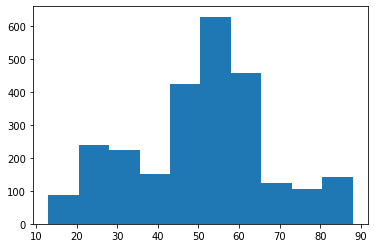

In [168]:
num, bins, fig = plt.hist(bpms)

Maybe we can just try to "cheat" and look for ECG residual noise and pulse artifact noise as data to predict BPM

In [214]:
from sklearn.preprocessing import KBinsDiscretizer
kbins = KBinsDiscretizer(20)
max_size = 500
kbins.fit(np.array(bpms[:max_size]).reshape(-1,1))

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


KBinsDiscretizer(encode='onehot', n_bins=20, strategy='quantile')

In [217]:
bins = kbins.bin_edges_[0]
bins

array([19.  , 28.  , 33.  , 42.  , 42.8 , 49.  , 52.  , 53.  , 54.  ,
       59.25, 61.  , 62.  , 62.1 , 75.  , 82.  ])

In [218]:
freq = [bpmbin/60 for bpmbin in [10] + bins + [100]]

In [38]:
def norm_num_peaks_func(n):
    return lambda x: feats.number_peaks(x, n) / len(x)

def norm_num_vals_func(n):
    return lambda x: feats.number_peaks(-x, n) / len(x)

def autocorrelation(lag):
    return lambda x: feats.autocorrelation(x, lag)


In [219]:
reload(read)
hedBPM = read.EdfFFTDatasetTransformer(edfRawDataBPM, freq_bins=freq, return_ann=False, n_process=7)
# hedDfBPM = read.SimpleHandEngineeredDataset(edfRawDataBPM, vectorize=None, max_size=pd.Timedelta(minutes=2), n_process = 4, features=[feats.abs_energy, max, min, norm_num_peaks_func(20), norm_num_vals_func(20), autocorrelation(60), feats.skewness, feats.standard_deviation], f_names=["abs_energy", "max", "min", "num_peaks", "num_valleys", "autocorrelation", "skewness", "stdev"])
# hedBPM = read.SimpleHandEngineeredDataset(edfRawDataBPM, vectorize="full", max_size=pd.Timedelta(minutes=2), n_process = 8, features=[feats.abs_energy, max, min, norm_num_peaks_func(20), norm_num_vals_func(20), autocorrelation(60), feats.skewness, feats.standard_deviation], f_names=["abs_energy", "max", "min", "num_peaks", "num_valleys", "autocorrelation", "skewness", "stdev"])

In [221]:
# import all the data!

allHandEngineeredDataBPM = hedBPM[:max_size]


Starting 7 processes
retrieving: 0
retrieving: 5
retrieving: 10
retrieving: 15
retrieving: 20
retrieving: 25
retrieving: 30
retrieving: 35
retrieving: 40
retrieving: 45
retrieving: 50
retrieving: 55
retrieving: 60
retrieving: 65
retrieving: 70
retrieving: 75
retrieving: 80
retrieving: 85
retrieving: 90
retrieving: 95
retrieving: 100
retrieving: 105
retrieving: 110
retrieving: 115
retrieving: 120
retrieving: 125
retrieving: 130
retrieving: 135
retrieving: 140
retrieving: 145
retrieving: 150
retrieving: 155
retrieving: 160
retrieving: 165
retrieving: 170
retrieving: 175
retrieving: 180
retrieving: 185
retrieving: 190
retrieving: 195
retrieving: 200
retrieving: 205
retrieving: 210
retrieving: 215
retrieving: 220
retrieving: 225
retrieving: 230
retrieving: 235
retrieving: 240
retrieving: 245
retrieving: 250
retrieving: 255
retrieving: 260
retrieving: 265
retrieving: 270
retrieving: 275
retrieving: 280
retrieving: 285
retrieving: 290
retrieving: 295
retrieving: 300
retrieving: 305
retrievin

In [222]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
mm = MinMaxScaler()
lr = LinearRegression()

In [15]:
sum([type(datum) == int for datum in allHandEngineeredDataBPM])

NameError: name 'allHandEngineeredDataBPM' is not defined

In [224]:
trainDataBPM, testDataBPM, trainBPM, testBPM = train_test_split(allHandEngineeredDataBPM, bpms[:max_size])
# trainSliceBPM = slice(max_size - 100)
# testSliceBPM = slice(-100, None)
# allHandEngineeredData = np.nan_to_num(allHandEngineeredDataBPM)
# trainDataBPM = (mm.fit_transform(np.stack(allHandEngineeredDataBPM[trainSlice])))
# testDataBPM = (mm.fit_transform(np.stack(allHandEngineeredDataBPM[testSlice])))
# trainAgesBPM = (np.array(bpms[trainSlice]).reshape(-1,1))
# testAgesBPM = (np.array(bpms[testSlice]).reshape(-1,1))
# trainDataBPM.shape
# testDataBPM.shape

In [233]:

flattenedTrainDataBPM = mm.fit_transform([datum.values.reshape(-1) for datum in trainDataBPM])
flattenedTestDataBPM = mm.fit_transform([datum.values.reshape(-1) for datum in testDataBPM])


In [239]:
lr.fit(flattenedTrainDataBPM, trainBPM)
y_pred = lr.predict(flattenedTestDataBPM)
y_pred[y_pred < 10] = 10
y_pred[y_pred > 90] = 90
r2_score(y_pred, testBPM)

-0.9567294617615354

adjusted r^2 score -0.9567294617615354
r score  (0.16560851861386308, 0.06493217995374931)
r^2 score  0.027426181437478235


Text(0, 0.5, 'Actual')

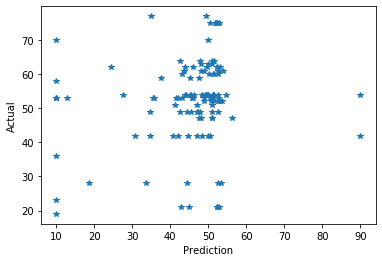

In [240]:
from scipy.stats import pearsonr
print('adjusted r^2 score', r2_score(y_pred, testBPM))
print('r score ', pearsonr(y_pred.reshape(-1), testBPM))
print('r^2 score ', pearsonr(y_pred.reshape(-1), testBPM)[0]**2)
plt.plot(y_pred, testBPM, "*")
plt.xlabel("Prediction")
plt.ylabel("Actual")

(array([ 15.,  16.,   9.,  39.,  42., 145.,  83.,   5.,  20.,   1.]),
 array([19. , 25.3, 31.6, 37.9, 44.2, 50.5, 56.8, 63.1, 69.4, 75.7, 82. ]),
 <a list of 10 Patch objects>)

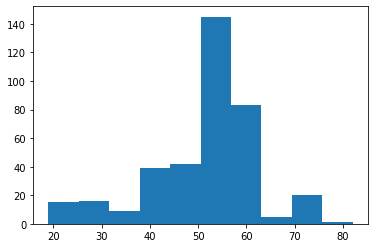

In [248]:
plt.hist(trainBPM)

(array([ 7.,  5.,  1., 10.,  5., 35., 26., 25.,  2.,  9.]),
 array([19. , 24.8, 30.6, 36.4, 42.2, 48. , 53.8, 59.6, 65.4, 71.2, 77. ]),
 <a list of 10 Patch objects>)

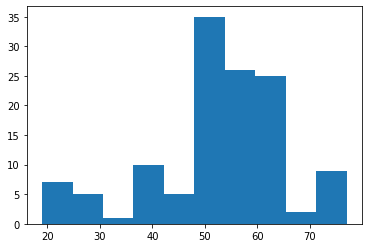

In [250]:
plt.hist(testBPM)

adjusted r^2 score -2.0090505859546384
r score  (0.3508744804312407, 6.025753922801626e-05)
r^2 score  0.12311290101789311


Text(0, 0.5, 'Actual')

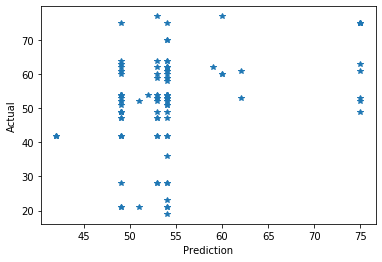

In [247]:
from sklearn.ensemble import RandomForestClassifier as RF
from scipy.stats.stats import pearsonr
rf = RF(n_estimators=10, max_depth=6)
rf.fit(np.nan_to_num(flattenedTrainDataBPM), trainBPM)
y_pred = rf.predict(flattenedTestDataBPM)
plt.plot(y_pred, testBPM, "*")
print('adjusted r^2 score', r2_score(y_pred, testBPM))
print('r score ', pearsonr(y_pred, testBPM))
print('r^2 score ', pearsonr(y_pred, testBPM)[0]**2)

plt.xlabel("Prediction")
plt.ylabel("Actual")

# Gender

In [4]:
reload(read)
res = cta.getGenderAndFileNames("train", "01_tcp_ar")
singGenders = [datum[1] for datum in res]
fn = [datum[0] for datum in res]
genders = []
#associate first token file with each session for now
tokenFiles = []
for i, session_file in enumerate(fn):
    session_dir = path.dirname(session_file)
    session_tkn_files = read.get_token_file_names(session_dir)
    session_tkn_files.sort()
    tokenFiles += (session_tkn_files)
    genders += [singGenders[i] for j in session_tkn_files]


Text(0.5, 1.0, 'Train Distribution')

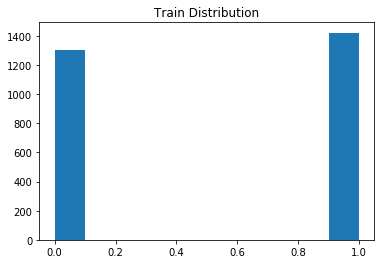

In [7]:
plt.hist([1 if gender=='m' else 0 for gender in genders])
plt.title("Train Distribution")

In [9]:
reload(read)
res = cta.getGenderAndFileNames("dev_test", "01_tcp_ar")
singGenders = [datum[1] for datum in res]
fn = [datum[0] for datum in res]
genders = []
#associate first token file with each session for now
tokenFiles = []
for i, session_file in enumerate(fn):
    session_dir = path.dirname(session_file)
    session_tkn_files = read.get_token_file_names(session_dir)
    session_tkn_files.sort()
    tokenFiles += (session_tkn_files)
    genders += [singGenders[i] for j in session_tkn_files]


Text(0.5, 1.0, 'Test Distribution')

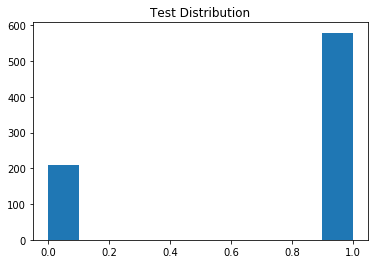

In [12]:
plt.hist([1 if gender=='m' else 0 for gender in genders])
plt.title("Test Distribution")

In [14]:
sum([1 if gender=='m' else 0 for gender in genders])/len(genders)

0.735705209656925

In [38]:
#percentage of genders recovered
len(singGenders)/ len(read.get_session_dir_names("train", "01_tcp_ar"))

0.8730385164051355

In [105]:

#based on https://www.ers-education.org/lrmedia/2016/pdf/298830.pdf
columns_to_use = ['EEG F4-REF','EEG C4-REF','EEG O2-REF',]
edfRawData = read.EdfDataset("train", "01_tcp_ar", n_process=7, filter=False, columns_to_use=columns_to_use, expand_tse=False)
edfRawData.edf_tokens=tokenFiles
edfABTGData = read.EdfFFTDatasetTransformer(edfRawData, freq_bins=[0,3.5,6,7.5,14,40], return_ann=False, n_process=7) #gamma, theta, alpha, beta

In [98]:
edfABTGData.edf_dataset.columns_to_use

['EEG F4-REF', 'EEG C4-REF', 'EEG O2-REF']

In [112]:
max_size = 800
data = edfABTGData[:max_size]

Starting 7 processes
retrieving: 0
retrieving: 5
retrieving: 10
retrieving: 15
retrieving: 20
retrieving: 25
retrieving: 30
retrieving: 35
retrieving: 40
retrieving: 45
retrieving: 50
retrieving: 55
retrieving: 60
retrieving: 65
retrieving: 70
retrieving: 75
retrieving: 80
retrieving: 85
retrieving: 90
retrieving: 95
retrieving: 100
retrieving: 105
retrieving: 110
retrieving: 115
retrieving: 120
retrieving: 125
retrieving: 130
retrieving: 135
retrieving: 140
retrieving: 145
retrieving: 150
retrieving: 155
retrieving: 160
retrieving: 165
retrieving: 170
retrieving: 175
retrieving: 180
retrieving: 185
retrieving: 190
retrieving: 195
retrieving: 200
retrieving: 205
retrieving: 210
retrieving: 215
retrieving: 220
retrieving: 225
retrieving: 230
retrieving: 235
retrieving: 240
retrieving: 245
retrieving: 250
retrieving: 255
retrieving: 260
retrieving: 265
retrieving: 270
retrieving: 275
retrieving: 280
retrieving: 285
retrieving: 290
retrieving: 295
retrieving: 300
retrieving: 305
retrievin

In [113]:
allData = np.stack([datum.values.reshape(-1) for datum in data])

In [92]:
np.isnan(allData).any().any()

False

In [115]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

mm = MinMaxScaler()
numericGenders = np.array([1 if gend=='m' else 0 for gend in genders])
trainSliceG = slice(max_size - 100)
testSliceG = slice(-100, None)

print(max_size)
trainDataG, testDataG, trainGenders, testGenders = train_test_split(allData, numericGenders[:max_size], stratify=numericGenders[:max_size], test_size=0.25)

# trainDataG = ((np.stack(allData[trainSliceG])))
# testDataG = ((np.stack(allData[testSliceG])))
# trainGenders = (np.array(numericGenders[trainSliceG]).reshape(-1,1))
# testGenders = (np.array(numericGenders[testSliceG]).reshape(-1,1))
# trainDataG.shape
# testDataG.shape
# trainGenders.shape

800


In [ ]:
lr = LogisticRegression()
lr.fit(trainDataG, trainGenders)
y_pred = lr.predict(testDataG[:])
# r2_score(y_pred, testGenders)
from sklearn.metrics import auc, f1_score
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]
print(f1_score(testGenders, y_pred), accuracy_score(testGenders, y_pred))

# r2_score(y_pred, trainGenders)

# sum(trainGenders), sum(testGenders), len(trainGenders)

In [127]:
from sklearn.ensemble import RandomForestClassifier as RF
from scipy.stats.stats import pearsonr
from sklearn.metrics import f1_score
accuracies = []
f1_scores = []
for i in range(5):
    rf = RF(n_estimators=200, max_depth=10)
    rf.fit(np.nan_to_num(trainDataG), trainGenders)
    y_pred = rf.predict(testDataG)
#     plt.plot(y_pred, testGenders, "*")
# print('adjusted r^2 score', r2_score(y_pred, trainGenders))
# print('r score ', pearsonr(y_pred, testAgesBPM.reshape(-1)))
# print('r^2 score ', pearsonr(y_pred, testAgesBPM.reshape(-1))[0]**2)
    print('accuracy', accuracy_score(y_pred, testGenders))
    accuracies.append(accuracy_score(y_pred, testGenders))
    print('f1 score', f1_score(y_pred, testGenders))
    f1_scores.append(f1_score(y_pred, testGenders))
print(np.mean(accuracies))
print(np.mean(f1_scores))
# plt.xlabel("Prediction")
# plt.ylabel("Actual")

accuracy 0.705
f1 score 0.43809523809523815
accuracy 0.68
f1 score 0.38461538461538464
accuracy 0.72
f1 score 0.47169811320754707
accuracy 0.71
f1 score 0.4629629629629629
accuracy 0.705
f1 score 0.4587155963302752
0.704
0.44321745904228155


In [252]:
1 - sum(testGenders) / len(testGenders)

0.645

### Going to try to do analysis on the freq band now
https://www.nature.com/articles/s41598-018-21495-7
https://www.sciencedirect.com/science/article/pii/S0028393210004100?via%3Dihub